In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver



In [3]:
from transforms import transforms
from Decon import SpectralDecon

In [4]:
site = 'SiteD'
N_InInt = 32

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


In [5]:
specInst = SpectralDecon(np.asarray(depth_LT), np.asarray(d18O_LT),2000)
f, P1 = specInst.dct_psd()


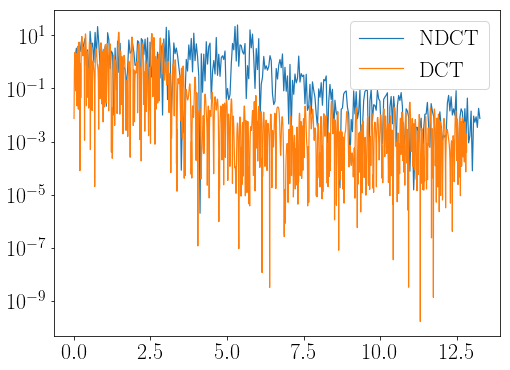

In [6]:
transInst = transforms(t_data = np.asarray(depth_LT), x_data = np.asarray(d18O_LT- np.mean(d18O_LT)), N=1*np.asarray(depth_LT).size)
w, X = transInst.NDCT()
P = abs(X)**2

fig, ax = plt.subplots(figsize=(8,6))
ax.semilogy(w[1:],P[1:], lw=1.2, label='NDCT')
ax.semilogy(f[1:],P1[1:], lw=1.2, label='DCT')
ax.legend()
#plt.semilogy(f[1:],P1[1:])


### Define data

In [7]:
site = 'SiteG'
N_InInt = 32

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']


### Compute diffusion length estimate interval

In [8]:
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

inst = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)

depthOpt, dataOpt, diffLen, peaks, arr_DiffLens, arr_Npeaks, arr_depth, arr_data = inst.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.668 cm
Final sigma: 8.46 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.020


In [9]:
idx32 = np.where(np.asarray(arr_Npeaks) == N_InInt)[0]
idx32Cut = idx32[:-1]

diffLens32 = np.asarray(arr_DiffLens)[idx32Cut]

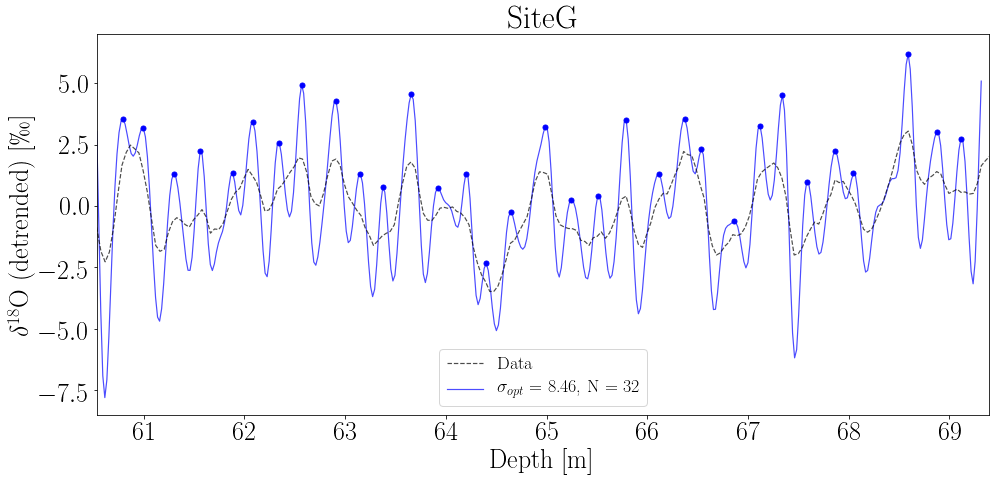

In [10]:
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depthOpt, dataOpt, label='$\sigma_{opt}$ = ' + f'{diffLen*100:.2f}, N = {len(peaks)}',zorder=-1, color='b', alpha=.7, lw=1.2)

plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]', title=site,xlim=(min(depth_LT),max(depth_LT)))
plt.scatter(depthOpt[peaks],dataOpt[peaks], color='b',zorder=1, s=25)


#fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens.png', bbox_inches='tight')


### Determine temperature estimate interval (analytical solution)

In [11]:
accum = accum0 

sigmaSolver_inst = sigma_Solver()

print(f'Accumulation estimate: {accum:.3f}')

print(f'Modern temperature estimate: {Temp0}\n')

T_intEst = np.zeros(len(diffLens32))

for i in range(len(diffLens32)):
    T_est = sigmaSolver_inst.solveTemp(sigma_data = diffLens32[i], accum = accum)# *(804.3/917.)
    T_intEst[i] = T_est
    if i%10 == 0:
        print(f'Computed temperature estimate: {T_est[0] - 273.15:.2f}')

Accumulation estimate: 0.251
Modern temperature estimate: -30.1

Computed temperature estimate: -31.38
Computed temperature estimate: -31.06
Computed temperature estimate: -30.70
Computed temperature estimate: -30.35
Computed temperature estimate: -30.01
Computed temperature estimate: -29.66
Computed temperature estimate: -29.32
Computed temperature estimate: -28.98
Computed temperature estimate: -28.65
Computed temperature estimate: -28.32


In [12]:
from TemperatureEstimates import TempEst_analytical
from TemperatureEstimates import TempEst_analytical_arr

In [13]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInt = [32, 33, 33, 32, 32, 32]

T_est = []
diffLens_est = []
for site, N in zip(sites,N_InInt):
    print(site+'\n')
    T, dL = TempEst_analytical(site, N)
    T_est.append(T)
    diffLens_est.append(dL)

SiteA

Starting sigma: 5.52 [cm]
Final sigma: 6.14 [cm]
Final # of peaks: 32
Delta: 0.038
Delta new: 0.019
SiteB

Starting sigma: 5.43 [cm]
Final sigma: 5.85 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019
SiteD

Starting sigma: 5.25 [cm]
Final sigma: 4.56 [cm]
Final # of peaks: 33
Delta: 0.037
Delta new: 0.019
SiteE

Starting sigma: 6.50 [cm]
Final sigma: 5.95 [cm]
Final # of peaks: 32
Delta: 0.041
Delta new: 0.021
SiteG

Starting sigma: 6.66 [cm]
100. Npeaks: 32, diffLen: 7.668 cm
Final sigma: 8.46 [cm]
Final # of peaks: 32
Delta: 0.040
Delta new: 0.020
Crete

No ECM file found, setting empty df instead
Starting sigma: 6.28 [cm]
Final sigma: 6.02 [cm]
Final # of peaks: 32
Delta: 0.026
Delta new: 0.013


SiteA T0 = -29.41
SiteB T0 = -29.77
SiteD T0 = -28.3
SiteE T0 = -30.37
SiteG T0 = -30.1
Crete T0 = -30.4


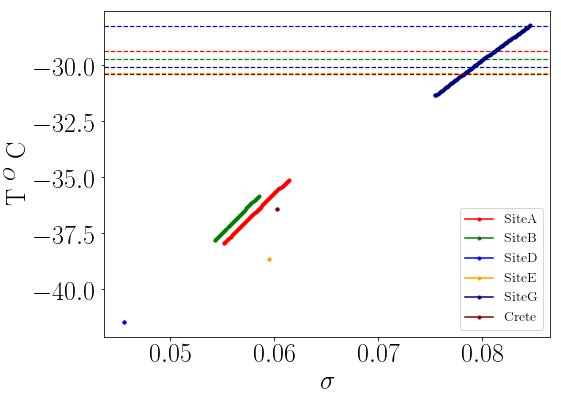

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

Ts = [-29.41, -29.77, -28.30, -30.37, -30.10, -30.40]
colors = ['red','green','blue','orange','navy','maroon']
for i in range(len(T_est)):
    #ax.axhline(y=Ts[i])
    print(f'{sites[i]} T0 = {Ts[i]}')
    ax.axhline(y=Ts[i],color=colors[i], lw=1.2, ls='--')
    ax.plot(diffLens_est[i], T_est[i]-273.15, label=sites[i],marker='.', color=colors[i])
ax.set(xlabel='$\sigma$', ylabel='T $^O$ C')    
ax.legend(fontsize=14)